# Introduction
This notebook is a first part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository meant to fetch and clean up the playlist and track information from the [eargasm music channel](https://open.spotify.com/user/eargasmusic?si=HtTLbkG6QoqkdKU3uTRjAQ) at Spotify.

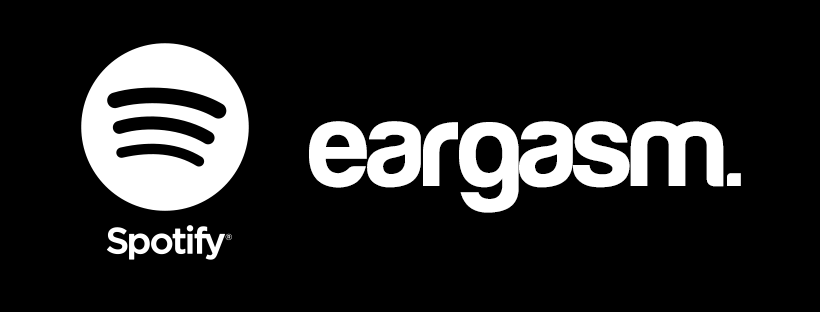

# Setup up the environment

## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


## Install extra libraries

### Spotipy
Spotipy handles the Spotify Web API.
https://spotipy.readthedocs.io/

In [3]:
!pip install spotipy

### Colab-env
- `colab-env` handles environment variables in Google Colab. ([link](https://pypi.org/project/colab-env/))

In [4]:
!pip install colab-env -qU

## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### System
- `os` - Miscellaneous operating system interfaces
- `timeit` - Measure execution time of small code snippets
- `colab_env` - Google Colab environment variables handling (*it will ask you to log in to your google account and enter your authorization code*)


In [5]:
import os
import timeit
import colab_env

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Notebook
- `IPython.display` `Audio` & `Image` - Audio & imagery handling
- `tqdm.notebook` `tqdm` - Progress bars ([link](https://github.com/tqdm/tqdm))

In [6]:
import IPython
from IPython.display import Image
from tqdm.notebook import tqdm

### Data science
- `pandas` - data manipulation & analysis
- `numpy` - linear algebra 

In [7]:
import pandas as pd
import numpy as np

### Spotify
- `spotipy` - Spotify Web API handling ([link](https://spotipy.readthedocs.io/))
- `SpotifyClientCredentials` - Spotify authentification

In [8]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Authentication
To authenticate the requests to the Spotify API I'll use [Spotipy](https://spotipy.readthedocs.io/) library. I'll use *Client Credentials Flow* method for authorization due to a higher rate limit and no need for `SPOTIPY_REDIRECT_URI`. 

Due to safety reasons the `client_id` & `client_secret` variables are loaded from the [colab-env](https://pypi.org/project/colab-env/) environment variables using `os.getenv()` method. 

After passing the variables to the `SpotifyClientCredentials()` module the `Spotify()` API client is created as `sp`. I set `request_timeout` parameter higher to avoid `ReadTimeoutError` errors,

In [9]:
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

client_credentials_manager = SpotifyClientCredentials(client_id=client_id,
                                                      client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager,
                     requests_timeout=20)

# Playlists
Let's fetch all the existing playlists from the [eargasm music channel](https://open.spotify.com/user/eargasmusic?si=HtTLbkG6QoqkdKU3uTRjAQ).


## Channel info
Basic channel information. *Feel free to change this for your own channel.*

1. Set the username
2. Create a user object
3. Iterate through dictionary to display basic info


In [10]:
USER_NAME = 'eargasmusic'
user = sp.user(USER_NAME)
for key, value in user.items():
  if key == 'images': IMAGE_URL=value[0]['url']
  print('{}: {}'.format(key, value))
Image(url = IMAGE_URL, width = 300, height = 300)

display_name: Eargasm Musicblog
external_urls: {'spotify': 'https://open.spotify.com/user/eargasmusic'}
followers: {'href': None, 'total': 337}
href: https://api.spotify.com/v1/users/eargasmusic
id: eargasmusic
images: [{'height': None, 'url': 'https://i.scdn.co/image/ab6775700000ee85c34f83b0dc82b7ff64a06ac5', 'width': None}]
type: user
uri: spotify:user:eargasmusic


## Playlists info
Let's fetch the list of available playlists, display number of playlists as well as their names.

***Disclaimer:*** *There are two types of playlists:*

*- named playlists containing songs of a similar mood/sentiment (i.e. `eargasm | curvatronic`),*

*- yearly playlists containing all songs posted in a given year (i.e. `eargasm music | 2017`).*

*I will mostly focus on the named playlists but I'll take advantage of the yearly playlists in latter notebooks.*


In [11]:
playlist_dict = sp.user_playlists(USER_NAME)
playlist_items = playlist_dict['items']

print('The channel contains a total of {} playlists:'.format(len(playlist_items)))
for item in playlist_items:
  print('Name: {}\n Number of tracks: {}\n'.format(item['name'], item['tracks']['total']))

The channel contains a total of 38 playlists:
Name: eargasm | breathe easy
 Number of tracks: 173

Name: eargasm | city walk
 Number of tracks: 242

Name: eargasm | curvatronik
 Number of tracks: 213

Name: eargasm | decadency
 Number of tracks: 68

Name: eargasm | deep water
 Number of tracks: 93

Name: eargasm | departure
 Number of tracks: 112

Name: eargasm | dust settling
 Number of tracks: 85

Name: eargasm | get moving
 Number of tracks: 125

Name: eargasm | glide
 Number of tracks: 83

Name: eargasm | high frequency radio
 Number of tracks: 170

Name: eargasm | into the wild
 Number of tracks: 75

Name: eargasm | joyride
 Number of tracks: 167

Name: eargasm | kickin' it ol' skool
 Number of tracks: 94

Name: eargasm | loungin'
 Number of tracks: 133

Name: eargasm | neon socks
 Number of tracks: 100

Name: eargasm | on top
 Number of tracks: 39

Name: eargasm | organised noise
 Number of tracks: 163

Name: eargasm | oscilloscope
 Number of tracks: 131

Name: eargasm | polymers

## All playlists DataFrame
Let's extract the basic information we need for each of the playlists and put them in a Pandas DataFrame. 

We can either do it by fetching fresh data from Spotify API or import previously saved CSV file.

1. Perform a list comprehension
2. Create a DataFrame based on the list of details
3. Display first rows and information

### Fetch data

In [12]:
playlist_details = [[item['id'],
                     item['name'],
                     item['external_urls']['spotify'],
                     item['images'][0]['url'],
                     item['tracks']['total']] for item in playlist_items]

all_playlists = pd.DataFrame(playlist_details,
                             columns=['id', 'name', 'url', 'image', 'tracks'])

In [13]:
all_playlists.head()

,id,name,url,image,tracks
0,5apHWYcigR3lSZpyzyGKEa,eargasm | breathe easy,https://open.spotify.com/playlist/5apHWYcigR3l...,https://i.scdn.co/image/ab67706c0000bebbd3ccf5...,173
1,3MXM4ca1b3bT198F7mG9ms,eargasm | city walk,https://open.spotify.com/playlist/3MXM4ca1b3bT...,https://i.scdn.co/image/ab67706c0000da84e10d9c...,242
2,2QdM3NBe7lkOzC7OqWXfNI,eargasm | curvatronik,https://open.spotify.com/playlist/2QdM3NBe7lkO...,https://i.scdn.co/image/ab67706c0000bebb2aa390...,213
3,1CwPTyGbQDSda6m7vTys1d,eargasm | decadency,https://open.spotify.com/playlist/1CwPTyGbQDSd...,https://i.scdn.co/image/ab67706c0000da84c70dd4...,68
4,6pGQQZ4PITmFnSC0rTnmXp,eargasm | deep water,https://open.spotify.com/playlist/6pGQQZ4PITmF...,https://i.scdn.co/image/ab67706c0000da846e34ff...,93


In [14]:
all_playlists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      38 non-null     object
 1   name    38 non-null     object
 2   url     38 non-null     object
 3   image   38 non-null     object
 4   tracks  38 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ KB


### Save to CSV
Let's export the DataFrame to external CSV file for backup and later use.

In [15]:
all_playlists.to_csv('files/all_playlists.csv')

### Load from CSV
Let's extract the basic information we need for each of the playlists and put them in a Pandas DataFrame using previously saved CSV to save time.

In [16]:
all_playlists = pd.read_csv('files/all_playlists.csv', index_col=0)

## Named & unnamed playlists DataFrames
Let's divide the `all_playlists` DataFrame into two seperate playlists for named and unnamed playlists.

1. Create a boolean filter Series to mask named and unnamed playlists based on the naming convention.
2. Mask `all_playlists` into `unnamed_playlists` and `named_playlists` using filter Series.


### Named playlists

In [17]:
named = all_playlists['name'].str.startswith('eargasm | ')
named_playlists = all_playlists[named.values]

In [18]:
named_playlists.head()

,id,name,url,image,tracks
0,5apHWYcigR3lSZpyzyGKEa,eargasm | breathe easy,https://open.spotify.com/playlist/5apHWYcigR3l...,https://i.scdn.co/image/ab67706c0000bebbd3ccf5...,173
1,3MXM4ca1b3bT198F7mG9ms,eargasm | city walk,https://open.spotify.com/playlist/3MXM4ca1b3bT...,https://i.scdn.co/image/ab67706c0000da84e10d9c...,242
2,2QdM3NBe7lkOzC7OqWXfNI,eargasm | curvatronik,https://open.spotify.com/playlist/2QdM3NBe7lkO...,https://i.scdn.co/image/ab67706c0000bebb2aa390...,213
3,1CwPTyGbQDSda6m7vTys1d,eargasm | decadency,https://open.spotify.com/playlist/1CwPTyGbQDSd...,https://i.scdn.co/image/ab67706c0000da84c70dd4...,68
4,6pGQQZ4PITmFnSC0rTnmXp,eargasm | deep water,https://open.spotify.com/playlist/6pGQQZ4PITmF...,https://i.scdn.co/image/ab67706c0000da846e34ff...,93


In [19]:
named_playlists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29 non-null     object
 1   name    29 non-null     object
 2   url     29 non-null     object
 3   image   29 non-null     object
 4   tracks  29 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.4+ KB


### Example named playlist
Let's see the example  named playlist information.

In [20]:
random_playlist_id = named_playlists['id'][np.random.randint(0, len(named_playlists['id']))]
random_filter = named_playlists['id'] == random_playlist_id
random_playlist_info = named_playlists[random_filter.values].iloc[0]
for key, value in random_playlist_info.iteritems():
    if key == 'image': IMAGE_URL=value
    else: print('{}: {}'.format(key, value))
Image(url = IMAGE_URL, width = 300, height = 300)

id: 1CwPTyGbQDSda6m7vTys1d
name: eargasm | decadency
url: https://open.spotify.com/playlist/1CwPTyGbQDSda6m7vTys1d
tracks: 68


### Unnamed playlists

In [21]:
unnamed = all_playlists['name'].str.startswith('eargasm music ')
unnamed_playlists = all_playlists[unnamed.values]
unnamed_playlists.reset_index(drop=True, inplace=True)

In [22]:
unnamed_playlists.head()

,id,name,url,image,tracks
0,43754bIdP7b0ygh8tTMenW,eargasm music 2020,https://open.spotify.com/playlist/43754bIdP7b0...,https://i.scdn.co/image/ab67706c0000da84c881c9...,254
1,0MsxZLGhAKJyBMXAfD03db,eargasm music 2019,https://open.spotify.com/playlist/0MsxZLGhAKJy...,https://i.scdn.co/image/ab67706c0000da84eabc26...,815
2,4tFrGBRcTYsrz5BwCGZS8L,eargasm music 2018,https://open.spotify.com/playlist/4tFrGBRcTYsr...,https://i.scdn.co/image/ab67706c0000bebb96c0b2...,826
3,0tNl58CSFwviwg7LxWzdwy,eargasm music 2017,https://open.spotify.com/playlist/0tNl58CSFwvi...,https://i.scdn.co/image/ab67706c0000da84b7c821...,876
4,2CDNi9K1M0ilAUQn1FTVp4,eargasm music 2016,https://open.spotify.com/playlist/2CDNi9K1M0il...,https://i.scdn.co/image/ab67706c0000bebbde6035...,61


In [23]:
unnamed_playlists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9 non-null      object
 1   name    9 non-null      object
 2   url     9 non-null      object
 3   image   9 non-null      object
 4   tracks  9 non-null      int64 
dtypes: int64(1), object(4)
memory usage: 488.0+ bytes


### Example unnamed playlist
Let's see the example unnamed playlist information.

In [24]:
random_playlist_id = unnamed_playlists['id'][np.random.randint(0, len(unnamed_playlists['id']))]
random_filter = unnamed_playlists['id'] == random_playlist_id
random_playlist_info = unnamed_playlists[random_filter.values].iloc[0]
for key, value in random_playlist_info.iteritems():
    if key == 'image': IMAGE_URL=value
    else: print('{}: {}'.format(key, value))
Image(url = IMAGE_URL, width = 300, height = 300)

id: 43754bIdP7b0ygh8tTMenW
name: eargasm music 2020
url: https://open.spotify.com/playlist/43754bIdP7b0ygh8tTMenW
tracks: 254


# Tracks
Now, let's gather information about track in the playlists. I'll fetch:
1. Basic track information from [Get a Track](https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/) using `sp.playlist_items()`
2. Audio features from [Get Audio Features for a Track](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) using `sp.audio_features()`
3. Audio analysis from [Get Audio Analysis for a Track](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/) using `sp.audio_analysis()`

## Basic information
Let's fetch the basic track info we need from `sp.playlist_items()` object and save it to DataFrame.
- **id** - individual track is (*string*)
- **artist** - artist name (*string*)
- **name** - track name (*string*)
- **duration_ms** - duration in miliseconds (*integer*)
- **popularity** - popularity of the track (*integer from 0 to 100*) 
- **release_date** - album release_date (*string*)
- **preview** - 30-sec mp3 track preview link (*string*)
- **url** - Spotify URL for the track (*string*)

### Initiate variables

In [25]:
track_id = []
track_artist = []
track_artistid = []
track_name = []
track_duration = []
track_popularity = []
track_releasedate = []
track_preview = []
track_image = []
track_url = []
track_playlist = []

### Fetch data 
Let's now fetch the tracks data for each of the named playlists using from `sp.playlist_items()`. The loops iterate through (starting from the most outer):
1. Named playlists ids
2. Chunks of 100 tracks within a playlist (*To bypass the Spotify query limit*)
3. Catalog information of a single track

***Disclaimer:*** *For convenience I'll use `timeit` to check the runtime of the cell as well as `tqdm()` for a progress bar.*

In [26]:
start = timeit.default_timer()

for playlist_id in tqdm(named_playlists['id']):
  
  for i in range(0,10000,100):
    playlist_items = sp.playlist_items(playlist_id, limit=100, offset=i)['items']

    for item in playlist_items:
      track_id.append(item['track']['id'])
      track_artist.append(item['track']['artists'][0]['name'])
      track_artistid.append(item['track']['artists'][0]['id'])
      track_name.append(item['track']['name'])
      track_duration.append(item['track']['duration_ms'])
      track_popularity.append(item['track']['popularity'])
      track_releasedate.append(item['track']['album']['release_date'])
      track_preview.append(item['track']['preview_url'])
      track_image.append(item['track']['album']['images'][0]['url'])
      track_url.append(item['track']['external_urls']['spotify'])
      track_playlist.append(sp.playlist(playlist_id)['name'])  
    
stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))


Runtime: 751.9583260109999 seconds.


### Create a DataFrame
Let's create a DataFrame using created variables.

In [27]:
basic_info_df = pd.DataFrame({'track_id': track_id,
                              'track_artist': track_artist,
                              'track_artistid': track_artistid,
                              'track_name': track_name,
                              'track_duration': track_duration,
                              'track_popularity': track_popularity,
                              'track_releasedate': track_releasedate,
                              'track_preview': track_preview,
                              'track_image': track_image,
                              'track_url': track_url,
                              'track_playlist': track_playlist})

In [28]:
basic_info_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,42,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,51,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,None,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,None,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy


In [29]:
basic_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621 entries, 0 to 3620
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   track_id           3621 non-null   object
 1   track_artist       3621 non-null   object
 2   track_artistid     3621 non-null   object
 3   track_name         3621 non-null   object
 4   track_duration     3621 non-null   int64 
 5   track_popularity   3621 non-null   int64 
 6   track_releasedate  3621 non-null   object
 7   track_preview      2530 non-null   object
 8   track_image        3621 non-null   object
 9   track_url          3621 non-null   object
 10  track_playlist     3621 non-null   object
dtypes: int64(2), object(9)
memory usage: 311.3+ KB


###Save to CSV
Export the basic information DataFrame to external CSV file.

In [30]:
basic_info_df.to_csv('files/basic_info.csv')

### Load from CSV
Import the basic track information from previously saved CSV file and put it into a Pandas DataFrame.

In [31]:
basic_info_df = pd.read_csv('files/basic_info.csv', index_col=0)

### Example track basic info
Let's see the example track basic information.

In [32]:
random_track_id = basic_info_df['track_id'][np.random.randint(0, len(basic_info_df['track_id']))]
random_filter = basic_info_df['track_id'] == random_track_id
random_track_info = basic_info_df[random_filter.values].iloc[0]
PREVIEW_URL = ''
IMAGE_URL = ''
for key, value in random_track_info.iteritems():
  
  if key == 'track_preview' and isinstance(value, str):
    PREVIEW_URL = value+'.mp3'
  elif key == 'track_image' and isinstance(value, str):
    IMAGE_URL = value
  print('{}: {}'.format(key, value))

IPython.display.Audio(url=PREVIEW_URL, embed=True)
Image(url=IMAGE_URL, width=300, height=300)

track_id: 46sb6EWJU61XvInrSlyoya
track_artist: Titeknots
track_artistid: 0CdxxbmCwuQ0dV9LvvyqlO
track_name: Mustard Flower
track_duration: 298557
track_popularity: 37
track_releasedate: 2017-04-14
track_preview: https://p.scdn.co/mp3-preview/84ae95f7fbecf68b261ca01f506cb4722a287f3e?cid=6f8f846f86b24d08a3de0e01d381894a
track_image: https://i.scdn.co/image/ab67616d0000b27373366fd98d2d79abc06c7d29
track_url: https://open.spotify.com/track/46sb6EWJU61XvInrSlyoya
track_playlist: eargasm | curvatronik


## Audio features
Let's fetch the audio features of track info we need from `sp.audio_features()` object and save it to DataFrame.

- **id** - individual track is (*string*)
- **danceability** - suitability of a track for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity (*float between 0.0 and 1.0*)
- **energy** - perceptual measure of intensity and activity; perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy (*float between 0.0 and 1.0*)
- **speechiness** - presence of spoken words in a track; speech-like recordings - the closer to 1.0, above 0.66 tracks probably made entirely of spoken words above 0.66, track with both music and speech between 0.33 and 0.66, music and instrumental tracks below 0.33 (*float between 0.0 and 1.0*)
- **acousticness** - confidence measure wheather the track is acoustic (*float between 0.0 and 1.0*)
- **instrumnetalness** - confidence measure wheather the track contains no vocals (*float between 0.0 and 1.0*)
- **liveness** - confidence measure wheather the song was recorded live (detects audience in the recording) (**float between 0.0 and 1.0*)
- **valence** - describes the musical positiveness conveyed by a track (*float between 0.0 and 1.0*)


### The function
Let's build a function which takes the track id and returns a dictionary of features of our choice using `sp.audio_features()` method.

In [33]:
def audio_features(id):
    all_features = sp.audio_features(id)[0]
    columns_to_keep = ['id',
                       'danceability',
                       'energy',
                       'speechiness',
                       'acousticness',
                       'instrumentalness',
                       'liveness',
                       'valence']
    selected_features = { column: all_features[column] for column in columns_to_keep }
    
    return selected_features

### Example audio features
Let's fetch the sample of audio features for a random song in our set and see if the features align with real world listening experience.

1. Get a random track id
2. Print the track artist and name using `basic_info_df`
3. Extract the audio features using `audio_features()` function
4. Extract the 30-second mp3 preview URL if exists
5. Play the track preview

In [40]:
random_track_id = basic_info_df['track_id'][np.random.randint(0, len(basic_info_df['track_id']))]

df = basic_info_df.loc[basic_info_df['track_id'] == random_track_id]
# print(df.iloc[0].loc[['track_artists', 'track_name']])
print(df)

for feature, value in audio_features(random_track_id).items():
  print(feature, value) 
  
PREVIEW_URL = df.iloc[0].loc[['track_preview']][0]
if isinstance(PREVIEW_URL, str):
  PREVIEW_URL = PREVIEW_URL+'.mp3'
else: PREVIEW_URL = ''

IPython.display.Audio(url=PREVIEW_URL, embed=True)

                    track_id  ...     track_playlist
1605  66z9nTAcrwXLTC6MNyDwBn  ...  eargasm | joyride

[1 rows x 11 columns]
id 66z9nTAcrwXLTC6MNyDwBn
danceability 0.603
energy 0.806
speechiness 0.0732
acousticness 0.0147
instrumentalness 0.00155
liveness 0.143
valence 0.62


### Fetch data and create a DataFrame
Let's now fetch the audio features of each track in the `basic_info_df` DataFrame using our `audio_features()` function and create the `audio_features_df` DataFrame cointaining all the data retrieved. I'll also change the id column name to track_id.

***Disclaimer:*** *For convenience I'll use timeit to check the runtime of the cell as well as tqdm() for a progress bar.*

In [ ]:
start = timeit.default_timer()

audio_features_df = pd.DataFrame()

for track_id in tqdm(basic_info_df['track_id']):
    features = audio_features(track_id)   
    audio_features_df = audio_features_df.append(features, ignore_index=True)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
audio_features_df.rename(columns={'id': 'track_id'},
                         inplace=True)

In [ ]:
audio_features_df.head()

In [ ]:
audio_features_df.info()

### Save to CSV
Let's export the DataFrame to external CSV file for backup and later use.

In [ ]:
audio_features_df.to_csv('files/audio_features.csv')

### Load from CSV
Import the audio features from previously saved CSV file and put it into a Pandas DataFrame.

In [ ]:
audio_features_df = pd.read_csv('files/audio_features.csv', index_col=0)

## Audio analysis
Let's fetch the audio analysis info we need from `sp.audio_analysis()` object and save it to DataFrame.

- **tempo** - the overall estimated tempo of the track in beats per minute (BPM) (*float*)
- **tempo_confidence** - the reliability of the tempo (*float between 0.0 to 1.0*)
- **time_signature** - tn estimated overall time signature of a track; the time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4. (*integer between 3 to 8*)
- **time-signature_confidence** - the reliability of the time signature (*float between 0.0 to 1.0*)
- **key** - the estimated overall key of the track; the values in this field range from 0 to 11 mapping to pitches using standard [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class) (i.e. 0 = C, 1 = C♯/D♭, 2 = D, and so on). If no key was detected, the value is -1.
- **key_confidence** - the reliability of the key (*float between 0.0 and 1.0*)
- **mode** - the modality (major or minor) of a track, the type of scale from which its melodic content is derived (*0 - minor, 1 - major, or -1 - no result*)
- **mode_confidence** - the reliability of the mode (*float between 0.0 and 1.0*)
- **number_of_sections** - the number of parts of the track defined by large variations in rhythm or timbre, e.g. chorus, verse, bridge, guitar solo, etc. 

### The function
Let's build a function which takes the track id and returns a dictionary of audio analysis features of our choice using sp.audio_analysis() method.

In [ ]:
def audio_analysis(id):
    track_features = sp.audio_analysis(id)['track']  
    
    columns_to_keep = ['tempo',
                       'tempo_confidence',
                       'time_signature',
                       'time_signature_confidence',
                       'key',
                       'key_confidence',
                       'mode',
                       'mode_confidence']
    
    selected_analysis = { column: track_features[column] for column in columns_to_keep }
    
    selected_analysis['number_of_sections'] = len(sp.audio_analysis(id)['sections'][0])
    selected_analysis['track_id'] = id
    
    return selected_analysis

### Example audio analysis
Let's fetch the sample of audio analysis for a random song in our set and see if the features align with real world listening experience.

1. Get a random track id
2. Print the track artist and name using `basic_info_df`
3. Extract the audio features using `audio_features()` function
4. Extract the 30-second mp3 preview URL if exists
5. Play the track preview

In [ ]:
random_track_id = basic_info_df['track_id'][np.random.randint(0, len(basic_info_df['track_id']))]

df = basic_info_df.loc[basic_info_df['track_id'] == random_track_id]
print(df.iloc[0].loc[['track_artists', 'track_name']])

for feature, value in audio_analysis(random_track_id).items():
  print(feature, value) 
  
PREVIEW_URL = df.iloc[0].loc[['track_preview']][0]
if isinstance(PREVIEW_URL, str):
  PREVIEW_URL = PREVIEW_URL+'.mp3'
else: PREVIEW_URL = ''
IPython.display.Audio(url=PREVIEW_URL, embed=True)

### Fetch data and create a DataFrame
Let's now fetch the audio analysis of each track in the basic_info_df DataFrame using our audio_analysis() function and create the audio_analysis_df DataFrame cointaining all the data retrieved. In order to deal with track with no audio analysis data I'll use `try except` statement and fill missing data with `NaN's`

***Disclaimer:*** *For convenience I'll use timeit to check the runtime of the cell as well as tqdm() for a progress bar.*

In [ ]:
start = timeit.default_timer()
audio_analysis_df = pd.DataFrame()


for track_id in tqdm(basic_info_df['track_id']):
    # Continue when encountered an error
    try:
        analysis = audio_analysis(track_id)
        audio_analysis_df = audio_analysis_df.append(analysis, ignore_index=True)
    except:
        audio_analysis_df = audio_analysis_df.append({'tempo': np.nan,
                                                      'tempo_confidence': np.nan,
                                                      'time_signature': np.nan,
                                                      'time_signature_confidence': np.nan,
                                                      'key': np.nan,
                                                      'key_confidence': np.nan,
                                                      'mode': np.nan,
                                                      'mode_confidence': np.nan,
                                                      'number_of_sections': np.nan,
                                                      'track_id': track_id},
                                                      ignore_index=True)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
audio_analysis_df.head()

In [ ]:
audio_analysis_df.info()

### Save to CSV
Let's export the DataFrame to external CSV file for backup and later use.

In [ ]:
audio_analysis_df.to_csv('files/audio_analysis.csv')

### Load from CSV
Import the audio analysis information from previously saved CSV file and put it into a Pandas DataFrame.

In [ ]:
audio_analysis_df = pd.read_csv('files/audio_analysis.csv', index_col=0)

## Genres
Spotify doesn't assign genre info for each track. Instead it provides a list of genres assigned to the artist. Even though it's quite a generalization, I will use artist genre for each track of a particular artist.

### Fetch data and create a DataFrame
Let's fetch the genres info for each track we need using `sp.artist()` object and artist ids from `basic_info_df` and save it to DataFrame.

***Disclaimer:*** *For convenience I'll use timeit to check the runtime of the cell as well as tqdm() for a progress bar. Contrary to `tqdm()` usage for `for` loops, you need to integrate it with Pandas using `tqdm.pandas()` and then replace `pd.apply()` method with `pd.progress_apply()`*

In [ ]:
tqdm.pandas()

start = timeit.default_timer()

genres_df = pd.DataFrame(basic_info_df['track_artistid'])
genres_df['track_genre'] = genres_df['track_artistid'].progress_apply(lambda x: np.nan if len(sp.artist(x)['genres']) == 0 else sp.artist(x)['genres'][0])


stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
genres_df.head()

In [ ]:
genres_df.info()

### Unique genres
Let's get an image of number of unique genres within the track set.

In [ ]:
genres_df['track_genre'].value_counts()

### Save to CSV
Let's export the DataFrame to external CSV file for backup and later use.

In [ ]:
genres_df.to_csv('files/genres.csv')

### Load from CSV
Import the audio analysis information from previously saved CSV file and put it into a Pandas DataFrame.

In [ ]:
genres_df = pd.read_csv('files/genres.csv', index_col=0)

## Merge DataFrames
Now, let's combine all previously fetched DataFrames.

### DataFrames summary

In [ ]:
print('Basic info DataFrame\'s shape:', basic_info_df.shape)
print('Columns: {}'.format(basic_info_df.columns))

print('Audio features DataFrame\'s shape:', audio_features_df.shape)
print('Columns: {}'.format(audio_features_df.columns))

print('Audio analysis DataFrame\'s shape:', audio_analysis_df.shape)
print('Columns: {}'.format(audio_analysis_df.columns))

print('Genres DataFrame\'s shape:', genres_df.shape)
print('Columns: {}'.format(genres_df.columns))

In [ ]:
basic_info_df.head()



In [ ]:
audio_features_df.head()

In [ ]:
audio_analysis_df.head()

In [ ]:
genres_df.head()

### Merge
1. I will first merge `audio_features_df` with `audio_analysis_df` which represent features for each individual track and then drop duplicates of the same `track_id`.
2. Secondly, I'll add genre info to the `basic_info_df` DataFrame.
3. Finally, I'll marge the `basic_info_df` with the `features_df` to add all the features to the entire list of tracks I fetched with a proper `track_playlist` label.

In [ ]:
features_df = audio_features_df.merge(audio_analysis_df,
                                      how='inner',
                                      on='track_id')

features_df.drop_duplicates(subset='track_id', inplace=True)

basic_info_df['track_genre'] = genres_df['track_genre']

final_df = basic_info_df.merge(features_df,
                               how='inner',
                               on='track_id')

In [ ]:
final_df.head()

In [ ]:
final_df.info()

### Save to CSV
Let's export the DataFrame to external CSV file for backup and later use.

In [ ]:
final_df.to_csv('files/final_df.csv')

### Load from CSV
Import the entire list of tracks with features from previously saved CSV file and put it into a Pandas DataFrame.

In [ ]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)

## References
For this part of the project I used mostly:

- Spotify Web API ([link](https://developer.spotify.com/documentation/web-api/))
- Spotipy library documentation ([link](https://spotipy.readthedocs.io/))